In [19]:
# Hysteresis model from Kut 2009/from Vilar 2002

# libs
import gillespy2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import find_peaks
import pandas as pd



def create_vilar_oscillator(parameter_values=None):
    # Initialize Model
    model = gillespy2.Model(name="VilarOscillator")
    
    # Set System Volume
    model.volume = 1

    # Define Variables (GillesPy2.Species)
    Da = gillespy2.Species(name="Da", initial_value=1, mode="discrete")
    Da_prime = gillespy2.Species(name="Da_prime", initial_value=0, mode="discrete")
    Ma = gillespy2.Species(name="Ma", initial_value=0, mode="discrete")
    Dr = gillespy2.Species(name="Dr", initial_value=1, mode="discrete")
    Dr_prime = gillespy2.Species(name="Dr_prime", initial_value=0, mode="discrete")
    Mr = gillespy2.Species(name="Mr", initial_value=0, mode="discrete")
    C = gillespy2.Species(name="C", initial_value=0, mode="discrete")
    A = gillespy2.Species(name="A", initial_value=0, mode="discrete")
    R = gillespy2.Species(name="R", initial_value=0, mode="discrete")

    # Add Variables to Model
    model.add_species([Da, Da_prime, Ma, Dr, Dr_prime, Mr, C, A, R])

    # Define Parameters
    alphaA = gillespy2.Parameter(name="alphaA", expression=50)
    alphaA_prime = gillespy2.Parameter(name="alphaA_prime", expression=500)
    alphaR = gillespy2.Parameter(name="alphaR", expression=0.01)
    alphaR_prime = gillespy2.Parameter(name="alphaR_prime", expression=50)
    
    betaA = gillespy2.Parameter(name="betaA", expression=50)
    betaR = gillespy2.Parameter(name="betaR", expression=5)
    
    deltaMA = gillespy2.Parameter(name="deltaMA", expression=10)
    deltaMR = gillespy2.Parameter(name="deltaMR", expression=0.5)
    deltaA = gillespy2.Parameter(name="deltaA", expression=1)
    deltaR = gillespy2.Parameter(name="deltaR", expression=0.2)
    
    gammaA = gillespy2.Parameter(name="gammaA", expression=1)
    gammaR = gillespy2.Parameter(name="gammaR", expression=1)
    gammaC = gillespy2.Parameter(name="gammaC", expression=2)
    
    thetaA = gillespy2.Parameter(name="thetaA", expression=50)
    thetaR = gillespy2.Parameter(name="thetaR", expression=100)

    # Add Parameters to Model
    model.add_parameter([alphaA, alphaA_prime, alphaR, alphaR_prime, betaA, betaR, deltaMA,deltaMR, deltaA, deltaR, gammaA, gammaR, gammaC, thetaA, thetaR])

    # Define Reactions
    #bound and unbound of DA/DR
    r1 = gillespy2.Reaction(name="r1", reactants={'A': 1, 'Da': 1}, products={'Da_prime': 1}, rate="gammaA")
    r2 = gillespy2.Reaction(name="r2", reactants={'Da_prime': 1}, products={'A': 1, 'Da': 1}, rate="thetaA")
    r3 = gillespy2.Reaction(name="r3", reactants={'A': 1, 'Dr': 1}, products={'Dr_prime': 1}, rate="gammaR")
    r4 = gillespy2.Reaction(name="r4", reactants={'Dr_prime': 1}, products={'A': 1, 'Dr': 1}, rate="thetaR")
    #transcription
    r5 = gillespy2.Reaction(name="r5", reactants={'Da': 1}, products={'Da': 1, 'Ma': 1}, rate="alphaA")
    r6 = gillespy2.Reaction(name="r6", reactants={'Da_prime': 1}, products={'Da_prime': 1, 'Ma': 1}, rate="alphaA_prime")
    r7 = gillespy2.Reaction(name="r7", reactants={'Dr': 1}, products={'Dr': 1, 'Mr': 1}, rate="alphaR")
    r8 = gillespy2.Reaction(name="r8", reactants={'Dr_prime': 1}, products={'Dr_prime': 1, 'Mr': 1}, rate="alphaR_prime")
    #translation
    r9 = gillespy2.Reaction(name="r9", reactants={'Ma': 1}, products={'A': 1, 'Ma': 1}, rate="betaA")
    r10 = gillespy2.Reaction(name="r10", reactants={'Mr': 1}, products={'Mr': 1, 'R': 1}, rate="betaR")    
    #complex formation
    r11 = gillespy2.Reaction(name="r11", reactants={'A': 1, 'R': 1}, products={'C': 1}, rate="gammaC")
    #degradation
    r12 = gillespy2.Reaction(name="r12", reactants={'A': 1}, products={}, rate="deltaA")
    r13 = gillespy2.Reaction(name="r13", reactants={'C': 1}, products={'R': 1}, rate="deltaA")
    r14 = gillespy2.Reaction(name="r14", reactants={'R': 1}, products={}, rate="deltaR")
    r15 = gillespy2.Reaction(name="r15", reactants={'Ma': 1}, products={}, rate="deltaMA")    
    r16 = gillespy2.Reaction(name="r16", reactants={'Mr': 1}, products={}, rate="deltaMR")

    # Add Reactions to Model
    model.add_reaction([r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15, r16])

    # Define Timespan
    tspan = gillespy2.TimeSpan.linspace(t=200, num_points=201)
    
    # Set Model Timespan
    model.timespan(tspan)
    return model

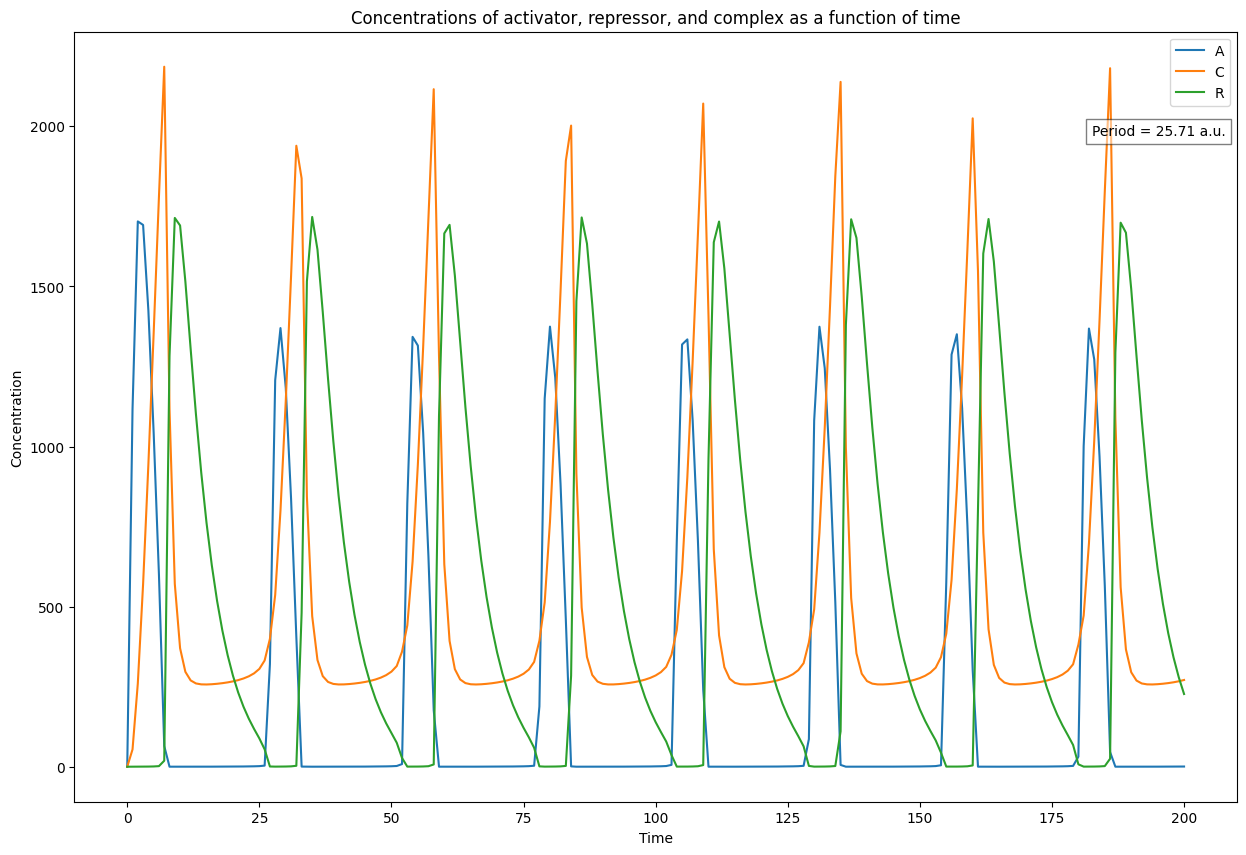

In [20]:
model = create_vilar_oscillator()

ode_results = model.run(algorithm="ODE")

plt.figure(figsize=(15, 10))
plt.title("Concentrations of activator, repressor, and complex as a function of time")
plt.xlabel('Time')
plt.ylabel('Concentration')

species_of_interest = ['A', 'C', 'R']

for species in species_of_interest:
    plt.plot(ode_results[0]['time'], ode_results[0][species], label=species)

# Calculate period from the time series data for one species (e.g., 'A')
species = 'A'
# Extract time series data
time_series = ode_results[0]['time']
concentration_series = ode_results[0][species]

# Find peaks in concentration series
peaks, _ = find_peaks(concentration_series, height=0)

# Compute period as the average time difference between consecutive peaks
period_lengths = np.diff(time_series[peaks])
period = np.mean(period_lengths)

# Add annotation to the plot
plt.text(
    0.99, 
    0.88,  # Adjust this value to place the annotation lower
    f"Period = {period:.2f} a.u.", 
    ha='right', 
    va='top', 
    fontsize=10, 
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.5)
)

plt.legend()
plt.show()


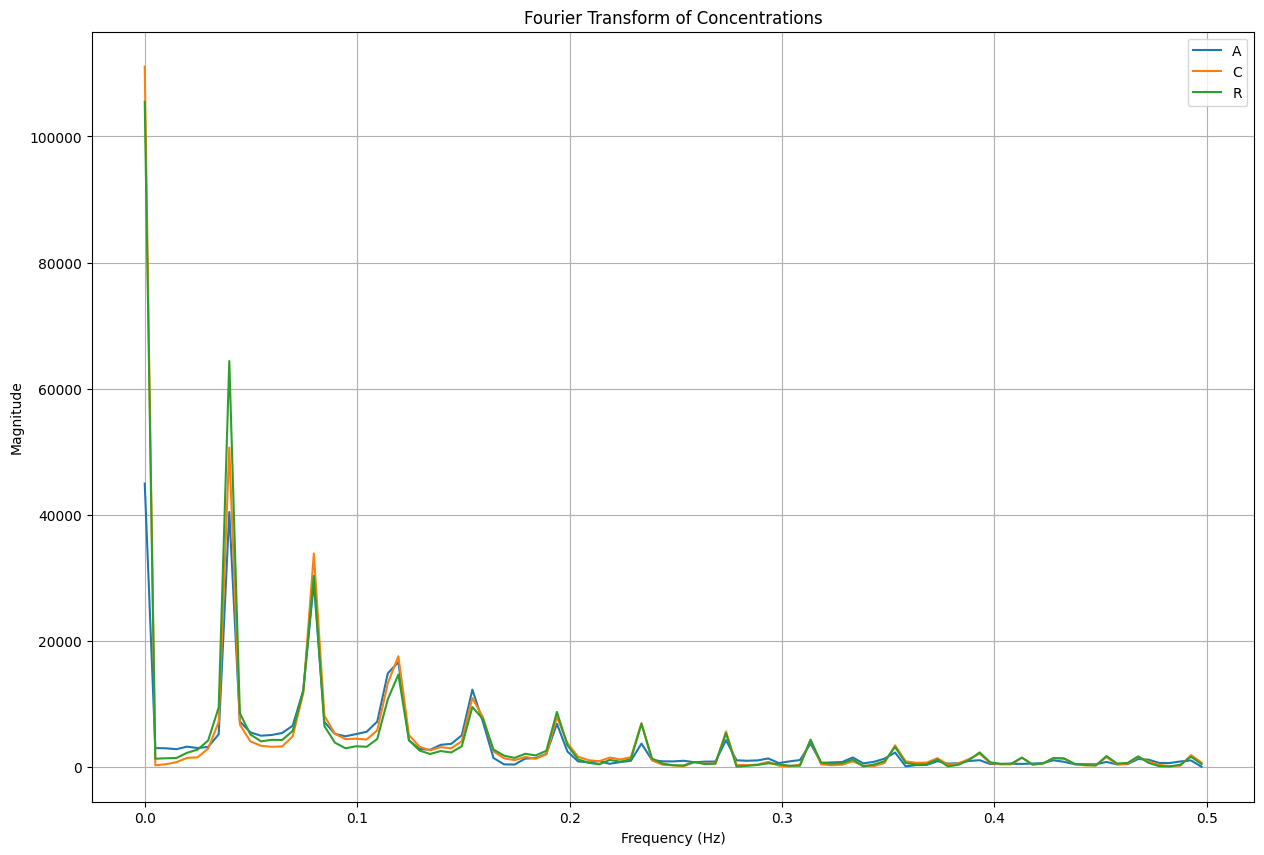


Top 10 Fourier components of species A:
   Frequency (Hz)     Magnitude
0        0.159204   7157.902866
1        0.109453   7214.537921
2        0.044776   7228.156795
3        0.074627  12139.517336
4        0.154229  12273.105587
5        0.114428  14861.387494
6        0.119403  16638.431533
7        0.079602  29287.258677
8        0.039801  40433.151668
9        0.000000  44949.093859

Top 10 Fourier components of species C:
   Frequency (Hz)      Magnitude
0        0.159204    7875.859462
1        0.194030    7933.985436
2        0.084577    8131.824153
3        0.154229   10958.138468
4        0.074627   11700.173370
5        0.114428   13291.366568
6        0.119403   17568.805138
7        0.079602   33856.888008
8        0.039801   50666.013080
9        0.000000  111048.884100

Top 10 Fourier components of species R:
   Frequency (Hz)      Magnitude
0        0.044776    8542.151522
1        0.194030    8743.931962
2        0.034826    9466.646376
3        0.154229    9510.1418

In [21]:
# Perform Fourier transformation for A, C, and R concentrations and print the top 10 Fourier components
species_data = {}

plt.figure(figsize=(15, 10))  # Create the figure outside the loop

for species in species_of_interest:
    # Compute the FFT
    fft_data = fft(ode_results[0][species])
    
    # Compute the corresponding frequencies
    freqs = np.fft.fftfreq(len(ode_results[0][species]), ode_results[0]['time'][1] - ode_results[0]['time'][0])

    # Only keep positive frequencies (including 0)
    positive_freq_indices = np.where(freqs >= 0)
    positive_freqs = freqs[positive_freq_indices]
    positive_fft_data = np.abs(fft_data[positive_freq_indices])

    # Find indices of top 10 frequencies
    top_indices = np.argsort(positive_fft_data)[-10:]
    
    # Get top 10 frequencies and their corresponding magnitudes
    top_freqs = positive_freqs[top_indices]
    top_fft_data = positive_fft_data[top_indices]

    # Plot the Fourier transform for each species
    plt.plot(positive_freqs, positive_fft_data, label=species)

    # Store data for printing top 10 Fourier components
    species_data[species] = {'Top Frequencies (Hz)': top_freqs, 'Top Magnitudes': top_fft_data}

plt.title("Fourier Transform of Concentrations")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True)
plt.show()

# Print out the top 10 Fourier components for each species
for species in ['A', 'C', 'R']:
    print(f"\nTop 10 Fourier components of species {species}:")
    top_freqs = species_data[species]['Top Frequencies (Hz)']
    top_magnitudes = species_data[species]['Top Magnitudes']
    print(pd.DataFrame({'Frequency (Hz)': top_freqs, 'Magnitude': top_magnitudes}))
